# Final Project

#### Install missing library

In [59]:
#!pip install tabulate

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score, f1_score
from tabulate import tabulate
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

#### Import data

In [61]:
Monday_df = pd.read_csv('archive_2/Monday_WorkingHours.csv')
Monday_df = pd.DataFrame(Monday_df) #Make into dataframe
print(Monday_df.shape) #Confirm shape
Monday_df.columns = Monday_df.columns.str.strip() #Remove extra spaces from column names

Tuesday_BruteForce = pd.read_csv('archive_2/Tuesday_BruteForce.csv')
Tuesday_BruteForce = pd.DataFrame(Tuesday_BruteForce)
print(Tuesday_BruteForce.shape)
Tuesday_BruteForce.columns = Tuesday_BruteForce.columns.str.strip()

Wednesday_DOS = pd.read_csv('archive_2/Wednesday_DOS_DDOS.csv')
Wednesday_DOS = pd.DataFrame(Wednesday_DOS)
print(Wednesday_DOS.shape)
Wednesday_DOS.columns = Wednesday_DOS.columns.str.strip() 

Thursday_WebAttack = pd.read_csv('archive_2/Thursday_Morning_WebAttacks.csv')
Thursday_WebAttack = pd.DataFrame(Thursday_WebAttack)
print(Thursday_WebAttack.shape)
Thursday_WebAttack.columns = Thursday_WebAttack.columns.str.strip()

Thursday_Infiltration = pd.read_csv('archive_2/Thursday_Afternoon_Infiltration.csv')
Thursday_Infiltration = pd.DataFrame(Thursday_Infiltration)
print(Thursday_Infiltration.shape)
Thursday_Infiltration.columns = Thursday_Infiltration.columns.str.strip()

Friday_Botnet = pd.read_csv('archive_2/Friday_Morning_Botnet.csv')
Friday_Botnet = pd.DataFrame(Friday_Botnet)
print(Friday_Botnet.shape)
Friday_Botnet.columns = Friday_Botnet.columns.str.strip()

Friday_Portscan = pd.read_csv('archive_2/Friday_Afternoon_PortScan.csv')
Friday_Portscan = pd.DataFrame(Friday_Portscan)
print(Friday_Portscan.shape)
Friday_Portscan.columns = Friday_Portscan.columns.str.strip()

Friday_DDOS = pd.read_csv('archive_2/Friday_Afternoon_DDos.csv')
Friday_DDOS = pd.DataFrame(Friday_DDOS)
print(Friday_DDOS.shape)
Friday_DDOS.columns = Friday_DDOS.columns.str.strip()

(529918, 79)
(445909, 79)
(692703, 79)
(170366, 79)
(288602, 79)
(191033, 79)
(286467, 79)
(225745, 79)


#### Explore columns to be removed

In [62]:
#Feature analysis function
def analyzeFeatures(df):
    results = {}
    # Duplicate columns
    checked = []
    duplicate_cols = []
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2 and col2 not in checked:
                if df[col1].equals(df[col2]):
                    duplicate_cols.append((col1,col2))
                    checked.append(col2)
    results['duplicates'] = duplicate_cols

    #Not unique columns
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    results['constant_cols'] = constant_cols

    #Missing value columns
    missing = df.isna().mean().sort_values(ascending=False)
    results['missing'] = missing[missing > 0].to_dict()

    return results

#Call for each dataset
Mon_features = analyzeFeatures(Monday_df)
BruteForce_features = analyzeFeatures(Tuesday_BruteForce)
DOS_features = analyzeFeatures(Wednesday_DOS)
WebAttack_features = analyzeFeatures(Thursday_WebAttack)
Infiltration_features = analyzeFeatures(Thursday_Infiltration)
Botnet_features = analyzeFeatures(Friday_Botnet)
Portscan_features = analyzeFeatures(Friday_Portscan)
DDOS_features = analyzeFeatures(Friday_DDOS)

#Store results in list
dataset_features = [Mon_features, BruteForce_features, DOS_features, WebAttack_features, Infiltration_features, Botnet_features, Portscan_features, DDOS_features]

#Function to summarize and aggregate results across datasets
def feature_summary(dataset_features):
    duplicate_lists = [set(map(tuple, d['duplicates'])) for d in dataset_features]
    constant_lists = [set(d['constant_cols']) for d in dataset_features]
    missing_lists = [set(d['missing'].keys()) for d in dataset_features]

    common_duplicates = set.intersection(*duplicate_lists) if duplicate_lists else set()
    common_constants = set.intersection(*constant_lists) if constant_lists else set()
    common_missing = set.intersection(*missing_lists) if missing_lists else set()

    return {
        'common_duplicate': sorted(list(common_duplicates)),
        'common_constant': sorted(list(common_constants)),
        'common_missing': sorted(list(common_missing))
    }

summary = feature_summary(dataset_features)
print(summary)

{'common_duplicate': [('Bwd PSH Flags', 'Bwd Avg Bulk Rate'), ('Bwd PSH Flags', 'Bwd Avg Bytes/Bulk'), ('Bwd PSH Flags', 'Bwd Avg Packets/Bulk'), ('Bwd PSH Flags', 'Bwd URG Flags'), ('Bwd PSH Flags', 'Fwd Avg Bulk Rate'), ('Bwd PSH Flags', 'Fwd Avg Bytes/Bulk'), ('Bwd PSH Flags', 'Fwd Avg Packets/Bulk'), ('Fwd Header Length', 'Fwd Header Length.1'), ('Fwd Header Length.1', 'Fwd Header Length'), ('Fwd PSH Flags', 'SYN Flag Count'), ('SYN Flag Count', 'Fwd PSH Flags'), ('Subflow Bwd Packets', 'Total Backward Packets'), ('Subflow Fwd Packets', 'Total Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Total Fwd Packets', 'Subflow Fwd Packets')], 'common_constant': ['Bwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk'], 'common_missing': ['Flow Bytes/s']}


#### Drop columns and create y dataframe

In [63]:
#Drop columns that are duplicates, provide cheating info (Destination Port), or aren't rich in information
def copyLabelDropColumns(df):
    yDF = df[['Label']].copy()
    newDF = df.drop(['Destination Port', 'Label', 'Bwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Header Length.1', 'Fwd PSH Flags', 'Subflow Bwd Packets','Subflow Fwd Packets'], axis=1)
    return yDF, newDF

In [64]:
#Calls to drop columns 
#Monday
Mon_df_y, Mon_drop_df = copyLabelDropColumns(Monday_df)
print(Mon_drop_df.shape) #Confirm correct shape remains

#Tuesday Brute Force
BruteForce_df_y, BruteForce_drop_df = copyLabelDropColumns(Tuesday_BruteForce)
print(BruteForce_drop_df.shape)

#Wednesday DOS
DOS_df_y, DOS_drop_df = copyLabelDropColumns(Wednesday_DOS)
print(DOS_drop_df.shape)

#Thursday Web Attack
WebAttack_df_y, WebAttack_drop_df = copyLabelDropColumns(Thursday_WebAttack)
print(WebAttack_drop_df.shape)

#Thursday Infiltration
Infiltration_df_y, Infiltration_drop_df = copyLabelDropColumns(Thursday_Infiltration)
print(Infiltration_drop_df.shape)

#Friday Botnet
Botnet_df_y, Botnet_drop_df = copyLabelDropColumns(Friday_Botnet)
print(Botnet_drop_df.shape)

#Friday Portscan
Portscan_df_y, Portscan_drop_df = copyLabelDropColumns(Friday_Portscan)
print(Portscan_drop_df.shape)

#Friday DDOS
DDOS_df_y, DDOS_drop_df = copyLabelDropColumns(Friday_DDOS)
print(DDOS_drop_df.shape)

(529918, 65)
(445909, 65)
(692703, 65)
(170366, 65)
(288602, 65)
(191033, 65)
(286467, 65)
(225745, 65)


#### What columns are left

In [65]:
print(DDOS_drop_df.columns)

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'URG Flag Count', 

#### Encode Labels

In [66]:
#Function to encode labels from benign and attack type labels
def encodeLabels(df):
    df['Label_encoding'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    df = df.drop(['Label'], axis=1)
    return df

Mon_df_y = encodeLabels(Mon_df_y)
Mon_df_y = Mon_df_y['Label_encoding'] 

BruteForce_df_y = encodeLabels(BruteForce_df_y)
BruteForce_df_y = BruteForce_df_y['Label_encoding'] 

DOS_df_y = encodeLabels(DOS_df_y)
DOS_df_y = DOS_df_y['Label_encoding'] 

WebAttack_df_y = encodeLabels(WebAttack_df_y)
WebAttack_df_y = WebAttack_df_y['Label_encoding']

Infiltration_df_y = encodeLabels(Infiltration_df_y)
Infiltration_df_y = Infiltration_df_y['Label_encoding']

Botnet_df_y = encodeLabels(Botnet_df_y)
Botnet_df_y = Botnet_df_y['Label_encoding']

Portscan_df_y = encodeLabels(Portscan_df_y)
Portscan_df_y = Portscan_df_y['Label_encoding']

DDOS_df_y = encodeLabels(DDOS_df_y)
DDOS_df_y = DDOS_df_y['Label_encoding']


#### Train test split all data

In [67]:
#Monday train, test split
X_Mon_train, X_Mon_test, Y_Mon_train, Y_Mon_test = train_test_split(
    Mon_drop_df, Mon_df_y, 
    test_size=.2, 
    stratify=Mon_df_y, 
    random_state=28)

In [68]:
#BruteForce train, test split
X_BruteForce_train, X_BruteForce_test, Y_BruteForce_train, Y_BruteForce_test = train_test_split(
    BruteForce_drop_df, BruteForce_df_y, 
    test_size=.2, 
    stratify=BruteForce_df_y, 
    random_state=28)

In [69]:
#DOS train, test split
X_DOS_train, X_DOS_test, Y_DOS_train, Y_DOS_test = train_test_split(
    DOS_drop_df, DOS_df_y, 
    test_size=.2, 
    stratify=DOS_df_y, 
    random_state=28)

In [70]:
#WebAttack train, test split
X_WebAttack_train, X_WebAttack_test, Y_WebAttack_train, Y_WebAttack_test = train_test_split(
    WebAttack_drop_df, WebAttack_df_y, 
    test_size=.2, 
    stratify=WebAttack_df_y, 
    random_state=28)

In [71]:
#Infiltration train, test split
X_Infiltration_train, X_Infiltration_test, Y_Infiltration_train, Y_Infiltration_test = train_test_split(
    Infiltration_drop_df, Infiltration_df_y, 
    test_size=.2, 
    stratify=Infiltration_df_y, 
    random_state=28)

In [72]:
#Botnet train, test split
X_Botnet_train, X_Botnet_test, Y_Botnet_train, Y_Botnet_test = train_test_split(
    Botnet_drop_df, Botnet_df_y, 
    test_size=.2, 
    stratify=Botnet_df_y, 
    random_state=28)

In [73]:
#Portscan train, test split
X_Portscan_train, X_Portscan_test, Y_Portscan_train, Y_Portscan_test = train_test_split(
    Portscan_drop_df, Portscan_df_y, 
    test_size=.2, 
    stratify=Portscan_df_y, 
    random_state=28)


In [74]:
#Portscan train, test split
X_DDOS_train, X_DDOS_test, Y_DDOS_train, Y_DDOS_test = train_test_split(
    DDOS_drop_df, DDOS_df_y, 
    test_size=.2, 
    stratify=DDOS_df_y, 
    random_state=28)


#### Add Monday to all attack days

In [75]:
def addMonday(x_train, x_test, y_train, y_test):
    concat_x_train = pd.concat([X_Mon_train, x_train], ignore_index=True)
    concat_x_test = pd.concat([X_Mon_test, x_test], ignore_index=True)
    concat_y_train = pd.concat([Y_Mon_train, y_train], ignore_index=True)
    concat_y_test = pd.concat([Y_Mon_test, y_test], ignore_index=True)
    return concat_x_train, concat_x_test, concat_y_train, concat_y_test

In [76]:
#Calls to concatenate Monday with all attack types
#Concat BruteForce
BruteForceMon_x_train, BruteForceMon_x_test, BruteForceMon_y_train, BruteForceMon_y_test = addMonday(X_BruteForce_train, X_BruteForce_test, Y_BruteForce_train, Y_BruteForce_test)

#Concat DOS
DOSMon_x_train, DOSMon_x_test, DOSMon_y_train, DOSMon_y_test = addMonday(X_DOS_train, X_DOS_test, Y_DOS_train, Y_DOS_test)

#Concat WebAttack
WebAttackMon_x_train, WebAttackMon_x_test, WebAttackMon_y_train, WebAttackMon_y_test = addMonday(X_WebAttack_train, X_WebAttack_test, Y_WebAttack_train, Y_WebAttack_test)

#Concat Infiltration
InfiltrationMon_x_train, InfiltrationMon_x_test, InfiltrationMon_y_train, InfiltrationMon_y_test = addMonday(X_Infiltration_train, X_Infiltration_test, Y_Infiltration_train, Y_Infiltration_test)

#Concat Botnet
BotnetMon_x_train, BotnetMon_x_test, BotnetMon_y_train, BotnetMon_y_test = addMonday(X_Botnet_train, X_Botnet_test, Y_Botnet_train, Y_Botnet_test)

#Concat Portscan
PortscanMon_x_train, PortscanMon_x_test, PortscanMon_y_train, PortscanMon_y_test = addMonday(X_Portscan_train, X_Portscan_test, Y_Portscan_train, Y_Portscan_test)

#Concat DDOS
DDOSMon_x_train, DDOSMon_x_test, DDOSMon_y_train, DDOSMon_y_test = addMonday(X_DDOS_train, X_DDOS_test, Y_DDOS_train, Y_DDOS_test)

#### Scale features

In [77]:
#Function to replace infinite with nan and then with median of the column
#and to scale the columns
def scaleFeatures(train, test):
    # Replace infinities with NaN
    train = train.replace([np.inf, -np.inf], np.nan)
    test  = test.replace([np.inf, -np.inf], np.nan)

    # Handle NaNs by filling with median of column
    train_medians = train.median()
    train = train.fillna(train_medians)
    test  = test.fillna(train_medians)

    #Declare scaler, fit on training
    scaler = MinMaxScaler().fit(train)

    #Transform train, test
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns)
    test_scaled  = pd.DataFrame(scaler.transform(test), columns=test.columns)

    return train_scaled, test_scaled

#Scale BruteForce
BruteForceMon_x_train, BruteForceMon_x_test = scaleFeatures(BruteForceMon_x_train, BruteForceMon_x_test)
#Scale DOS
DOSMon_x_train, DOSMon_x_test = scaleFeatures(DOSMon_x_train, DOSMon_x_test)
#Scale WebAttack
WebAttackMon_x_train, WebAttackMon_x_test = scaleFeatures(WebAttackMon_x_train, WebAttackMon_x_test)
#Scale Infiltration
InfiltrationMon_x_train, InfiltrationMon_x_test = scaleFeatures(InfiltrationMon_x_train, InfiltrationMon_x_test)
#Scale Botnet
BotnetMon_x_train, BotnetMon_x_test = scaleFeatures(BotnetMon_x_train, BotnetMon_x_test)
#Scale Portscan
PortscanMon_x_train, PortscanMon_x_test = scaleFeatures(PortscanMon_x_train, PortscanMon_x_test)
#Scale DDOS
DDOSMon_x_train, DDOSMon_x_test = scaleFeatures(DDOSMon_x_train, DDOSMon_x_test)

#### The Models

In [78]:
#Logistic Regression
logistic = LogisticRegression(max_iter=2000, class_weight='balanced')
#StratifiedkFold used to help with imbalanced datasets
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'Average Precision': 'average_precision', 'F1': 'f1'}
#Parameters considered
param_grid_logistic = [
   {
        'penalty': ['l2', 'l1'], 
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga']
    }
]
#Grid search parameters
grid_search_logistic = GridSearchCV(
    logistic, 
    param_grid=param_grid_logistic,
    refit='Average Precision', #refits estimator on the whole dataset with parameter setting
    cv=cv,
    n_jobs=1,
    scoring=scoring
)

In [79]:
#KNN
knn = KNeighborsClassifier()
#Parameters considered
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'leaf_size': [30, 40]
}
#Grid search parameters
grid_search_knn = GridSearchCV(
    knn,
    param_grid=param_grid_knn,
    refit='Average Precision',
    cv=cv,
    n_jobs=1,
    scoring=scoring
)

In [80]:
#Random Forest Classifier
random = RandomForestClassifier(random_state=42, class_weight='balanced')
#Parameters considered
param_grid_rf = {
    'n_estimators': [200, 500],       
    'max_depth': [None, 15, 30],      
    'min_samples_split': [2, 5],      
    'min_samples_leaf': [1, 2],       
    'max_features': ['sqrt'] 
}
#Grid search parameters
grid_search_rf = GridSearchCV(
    random,
    param_grid=param_grid_rf,
    refit='Average Precision',
    cv=cv,
    n_jobs=1,
    scoring=scoring   
)

In [81]:
#MLP Classifier
mlpclassifier = MLPClassifier(max_iter=2000)
#Parameters Considered
param_grid_mlp = {
   'hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'activation': ['relu'],     
    'solver': ['adam'],         
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['adaptive']
}
#Grid Search Parameters
grid_search_mlp = GridSearchCV(
   mlpclassifier,
   param_grid=param_grid_mlp,
   refit='Average Precision',
   cv=cv,
   n_jobs=1,
   scoring=scoring
)

#### Brute Force Analysis

In [82]:
#Hyperparameter training subset split
BruteForce_x_train_subset, _, BruteForce_y_train_subset, _ = train_test_split(
    BruteForceMon_x_train, BruteForceMon_y_train,
    train_size=0.05,            
    stratify=BruteForceMon_y_train,          
    random_state=42
)

#Logistic Regression
grid_search_logistic.fit(BruteForce_x_train_subset, BruteForce_y_train_subset)
BF_logistic_bestestimator = grid_search_logistic.best_estimator_
BF_logistic_bestparams = grid_search_logistic.best_params_
BF_logistic_bestscore = grid_search_logistic.best_score_
print('Brute Force')
print('Logistic Regression')
print("Best parameters:", BF_logistic_bestparams)
print("Best cross-val score: {:.2f}%".format(BF_logistic_bestscore * 100))
print('\n')

#KNN
grid_search_knn.fit(BruteForce_x_train_subset, BruteForce_y_train_subset)
BF_knn_bestestimator = grid_search_knn.best_estimator_
BF_knn_bestparams = grid_search_knn.best_params_
BF_knn_bestscore = grid_search_knn.best_score_
print('KNN')
print("Best parameters:", BF_knn_bestparams)
print("Best score: {:.2f}%".format(BF_knn_bestscore * 100))
print('\n')

#Random Forest Classifier
grid_search_rf.fit(BruteForce_x_train_subset, BruteForce_y_train_subset)
BF_rf_bestestimator = grid_search_rf.best_estimator_
BF_rf_bestparams = grid_search_rf.best_params_
BF_rf_bestscore = grid_search_rf.best_score_
print('Random Forest')
print("Best parameters:", BF_rf_bestparams)
print("Best score : {:.2f}%".format(BF_rf_bestscore * 100))
print('\n')

#MLP Classifier
grid_search_mlp.fit(BruteForce_x_train_subset, BruteForce_y_train_subset)
BF_mlp_bestestimator = grid_search_mlp.best_estimator_
BF_mlp_bestparams = grid_search_mlp.best_params_
BF_mlp_bestscore = grid_search_mlp.best_score_
print('Multi-Layer Perceptron')
print("Best parameters:", BF_mlp_bestparams)
print("Best score: {:.2f}%".format(BF_mlp_bestscore * 100))

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

Brute Force
Logistic Regression
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Best cross-val score: 62.86%


KNN
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'}
Best score: 98.04%


Random Forest
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score : 99.53%


Multi-Layer Perceptron
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 89.05%


#### DOS Analysis

In [83]:
#Hyperparameter training subset split
DOS_x_train_subset, _, DOS_y_train_subset, _ = train_test_split(
    DOSMon_x_train, DOSMon_y_train,
    train_size=0.05,            
    stratify=DOSMon_y_train,          
    random_state=42
)

#Logistic Regression
grid_search_logistic.fit(DOS_x_train_subset, DOS_y_train_subset)
DOS_logistic_bestestimator = grid_search_logistic.best_estimator_
DOS_logistic_bestparams = grid_search_logistic.best_params_
DOS_logistic_bestscore = grid_search_logistic.best_score_
print('DOS')
print('Logistic Regression')
print("Best parameters:", DOS_logistic_bestparams)
print("Best cross-val score: {:.2f}%".format(DOS_logistic_bestscore * 100))
print('\n')

#KNN
grid_search_knn.fit(DOS_x_train_subset, DOS_y_train_subset)
DOS_knn_bestestimator = grid_search_knn.best_estimator_
DOS_knn_bestparams = grid_search_knn.best_params_
DOS_knn_bestscore = grid_search_knn.best_score_
print('KNN')
print("Best parameters:", DOS_knn_bestparams)
print("Best score: {:.2f}%".format(DOS_knn_bestscore * 100))
print('\n')

#Random Forest Classifier
grid_search_rf.fit(DOS_x_train_subset, DOS_y_train_subset)
DOS_rf_bestestimator = grid_search_rf.best_estimator_
DOS_rf_bestparams = grid_search_rf.best_params_
DOS_rf_bestscore = grid_search_rf.best_score_
print('Random Forest')
print("Best parameters:", DOS_rf_bestparams)
print("Best score : {:.2f}%".format(DOS_rf_bestscore * 100))
print('\n')

#MLP Classifier
grid_search_mlp.fit(DOS_x_train_subset, DOS_y_train_subset)
DOS_mlp_bestestimator = grid_search_mlp.best_estimator_
DOS_mlp_bestparams = grid_search_mlp.best_params_
DOS_mlp_bestscore = grid_search_mlp.best_score_
print('Multi-Layer Perceptron')
print("Best parameters:", DOS_mlp_bestparams)
print("Best score: {:.2f}%".format(DOS_mlp_bestscore * 100))

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

DOS
Logistic Regression
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Best cross-val score: 95.65%


KNN
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 9, 'weights': 'distance'}
Best score: 99.48%


Random Forest
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best score : 99.98%


Multi-Layer Perceptron
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 99.22%


#### WebAttack Analysis

In [84]:
#Hyperparameter training subset split
WebAttack_x_train_subset, _, WebAttack_y_train_subset, _ = train_test_split(
    WebAttackMon_x_train, WebAttackMon_y_train,
    train_size=0.05,            
    stratify=WebAttackMon_y_train,          
    random_state=42
)

#Logistic Regression
grid_search_logistic.fit(WebAttack_x_train_subset, WebAttack_y_train_subset)
WebAttack_logistic_bestestimator = grid_search_logistic.best_estimator_
WebAttack_logistic_bestparams = grid_search_logistic.best_params_
WebAttack_logistic_bestscore = grid_search_logistic.best_score_
print('WebAttack')
print('Logistic Regression')
print("Best parameters:", WebAttack_logistic_bestparams)
print("Best cross-val score: {:.2f}%".format(WebAttack_logistic_bestscore * 100))
print('\n')

#KNN
grid_search_knn.fit(WebAttack_x_train_subset, WebAttack_y_train_subset)
WebAttack_knn_bestestimator = grid_search_knn.best_estimator_
WebAttack_knn_bestparams = grid_search_knn.best_params_
WebAttack_knn_bestscore = grid_search_knn.best_score_
print('KNN')
print("Best parameters:", WebAttack_knn_bestparams)
print("Best score: {:.2f}%".format(WebAttack_knn_bestscore * 100))
print('\n')

#Random Forest Classifier
grid_search_rf.fit(WebAttack_x_train_subset, WebAttack_y_train_subset)
WebAttack_rf_bestestimator = grid_search_rf.best_estimator_
WebAttack_rf_bestparams = grid_search_rf.best_params_
WebAttack_rf_bestscore = grid_search_rf.best_score_
print('Random Forest')
print("Best parameters:", WebAttack_rf_bestparams)
print("Best score : {:.2f}%".format(WebAttack_rf_bestscore * 100))
print('\n')

#MLP Classifier
grid_search_mlp.fit(WebAttack_x_train_subset, WebAttack_y_train_subset)
WebAttack_mlp_bestestimator = grid_search_mlp.best_estimator_
WebAttack_mlp_bestparams = grid_search_mlp.best_params_
WebAttack_mlp_bestscore = grid_search_mlp.best_score_
print('Multi-Layer Perceptron')
print("Best parameters:", WebAttack_mlp_bestparams)
print("Best score: {:.2f}%".format(WebAttack_mlp_bestscore * 100))

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

WebAttack
Logistic Regression
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Best cross-val score: 21.33%


KNN
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'}
Best score: 90.62%


Random Forest
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best score : 97.76%


Multi-Layer Perceptron
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 60.76%


#### Infiltration Analysis

In [85]:
#Hyperparameter training subset split
Infiltration_x_train_subset, _, Infiltration_y_train_subset, _ = train_test_split(
    InfiltrationMon_x_train, InfiltrationMon_y_train,
    train_size=0.1,            
    stratify=InfiltrationMon_y_train,          
    random_state=42
)

#Logistic Regression
grid_search_logistic.fit(Infiltration_x_train_subset, Infiltration_y_train_subset)
Infiltration_logistic_bestestimator = grid_search_logistic.best_estimator_
Infiltration_logistic_bestparams = grid_search_logistic.best_params_
Infiltration_logistic_bestscore = grid_search_logistic.best_score_
print('Infiltration')
print('Logistic Regression')
print("Best parameters:", Infiltration_logistic_bestparams)
print("Best cross-val score: {:.2f}%".format(Infiltration_logistic_bestscore * 100))
print('\n')

#KNN
grid_search_knn.fit(Infiltration_x_train_subset, Infiltration_y_train_subset)
Infiltration_knn_bestestimator = grid_search_knn.best_estimator_
Infiltration_knn_bestparams = grid_search_knn.best_params_
Infiltration_knn_bestscore = grid_search_knn.best_score_
print('KNN')
print("Best parameters:", Infiltration_knn_bestparams)
print("Best score: {:.2f}%".format(Infiltration_knn_bestscore * 100))
print('\n')

#Random Forest Classifier
grid_search_rf.fit(Infiltration_x_train_subset, Infiltration_y_train_subset)
Infiltration_rf_bestestimator = grid_search_rf.best_estimator_
Infiltration_rf_bestparams = grid_search_rf.best_params_
Infiltration_rf_bestscore = grid_search_rf.best_score_
print('Random Forest')
print("Best parameters:", Infiltration_rf_bestparams)
print("Best score : {:.2f}%".format(Infiltration_rf_bestscore * 100))
print('\n')

#MLP Classifier
grid_search_mlp.fit(Infiltration_x_train_subset, Infiltration_y_train_subset)
Infiltration_mlp_bestestimator = grid_search_mlp.best_estimator_
Infiltration_mlp_bestparams = grid_search_mlp.best_params_
Infiltration_mlp_bestscore = grid_search_mlp.best_score_
print('Multi-Layer Perceptron')
print("Best parameters:", Infiltration_mlp_bestparams)
print("Best score: {:.2f}%".format(Infiltration_mlp_bestscore * 100))

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

Infiltration
Logistic Regression
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best cross-val score: 1.75%


KNN
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
Best score: 0.00%


Random Forest
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score : 56.67%


Multi-Layer Perceptron
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 2.53%


#### Botnet Analysis

In [86]:
#Hyperparameter training subset split
Botnet_x_train_subset, _, Botnet_y_train_subset, _ = train_test_split(
    BotnetMon_x_train, BotnetMon_y_train,
    train_size=0.05,            
    stratify=BotnetMon_y_train,          
    random_state=42
)

#Logistic Regression
grid_search_logistic.fit(Botnet_x_train_subset, Botnet_y_train_subset)
Botnet_logistic_bestestimator = grid_search_logistic.best_estimator_
Botnet_logistic_bestparams = grid_search_logistic.best_params_
Botnet_logistic_bestscore = grid_search_logistic.best_score_
print('Botnet')
print('Logistic Regression')
print("Best parameters:", Botnet_logistic_bestparams)
print("Best cross-val score: {:.2f}%".format(Botnet_logistic_bestscore * 100))
print('\n')

#KNN
grid_search_knn.fit(Botnet_x_train_subset, Botnet_y_train_subset)
Botnet_knn_bestestimator = grid_search_knn.best_estimator_
Botnet_knn_bestparams = grid_search_knn.best_params_
Botnet_knn_bestscore = grid_search_knn.best_score_
print('KNN')
print("Best parameters:", Botnet_knn_bestparams)
print("Best score: {:.2f}%".format(Botnet_knn_bestscore * 100))
print('\n')

#Random Forest Classifier
grid_search_rf.fit(Botnet_x_train_subset, Botnet_y_train_subset)
Botnet_rf_bestestimator = grid_search_rf.best_estimator_
Botnet_rf_bestparams = grid_search_rf.best_params_
Botnet_rf_bestscore = grid_search_rf.best_score_
print('Random Forest')
print("Best parameters:", Botnet_rf_bestparams)
print("Best score : {:.2f}%".format(Botnet_rf_bestscore * 100))
print('\n')

#MLP Classifier
grid_search_mlp.fit(Botnet_x_train_subset, Botnet_y_train_subset)
Botnet_mlp_bestestimator = grid_search_mlp.best_estimator_
Botnet_mlp_bestparams = grid_search_mlp.best_params_
Botnet_mlp_bestscore = grid_search_mlp.best_score_
print('Multi-Layer Perceptron')
print("Best parameters:", Botnet_mlp_bestparams)
print("Best score: {:.2f}%".format(Botnet_mlp_bestscore * 100))

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

Botnet
Logistic Regression
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best cross-val score: 22.04%


KNN
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 9, 'weights': 'distance'}
Best score: 76.25%


Random Forest
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score : 89.01%


Multi-Layer Perceptron
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 49.29%


#### Portscan Analysis

In [87]:
#Hyperparameter training subset split
Portscan_x_train_subset, _, Portscan_y_train_subset, _ = train_test_split(
    PortscanMon_x_train, PortscanMon_y_train,
    train_size=0.05,            
    stratify=PortscanMon_y_train,          
    random_state=42
)

#Logistic Regression
grid_search_logistic.fit(Portscan_x_train_subset, Portscan_y_train_subset)
Portscan_logistic_bestestimator = grid_search_logistic.best_estimator_
Portscan_logistic_bestparams = grid_search_logistic.best_params_
Portscan_logistic_bestscore = grid_search_logistic.best_score_
print('Portscan')
print('Logistic Regression')
print("Best parameters:", Portscan_logistic_bestparams)
print("Best cross-val score: {:.2f}%".format(Portscan_logistic_bestscore * 100))
print('\n')

#KNN
grid_search_knn.fit(Portscan_x_train_subset, Portscan_y_train_subset)
Portscan_knn_bestestimator = grid_search_knn.best_estimator_
Portscan_knn_bestparams = grid_search_knn.best_params_
Portscan_knn_bestscore = grid_search_knn.best_score_
print('KNN')
print("Best parameters:", Portscan_knn_bestparams)
print("Best score: {:.2f}%".format(Portscan_knn_bestscore * 100))
print('\n')

#Random Forest Classifier
grid_search_rf.fit(Botnet_x_train_subset, Botnet_y_train_subset)
Portscan_rf_bestestimator = grid_search_rf.best_estimator_
Portscan_rf_bestparams = grid_search_rf.best_params_
Portscan_rf_bestscore = grid_search_rf.best_score_
print('Random Forest')
print("Best parameters:", Portscan_rf_bestparams)
print("Best score : {:.2f}%".format(Portscan_rf_bestscore * 100))
print('\n')

#MLP Classifier
grid_search_mlp.fit(Portscan_x_train_subset, Portscan_y_train_subset)
Portscan_mlp_bestestimator = grid_search_mlp.best_estimator_
Portscan_mlp_bestparams = grid_search_mlp.best_params_
Portscan_mlp_bestscore = grid_search_mlp.best_score_
print('Multi-Layer Perceptron')
print("Best parameters:", Portscan_mlp_bestparams)
print("Best score: {:.2f}%".format(Portscan_mlp_bestscore * 100))

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

Portscan
Logistic Regression
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Best cross-val score: 99.70%


KNN
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'distance'}
Best score: 99.95%


Random Forest
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score : 89.01%


Multi-Layer Perceptron
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 99.90%


#### DDOS Analysis

In [88]:
#Hyperparameter training subset split
DDOS_x_train_subset, _, DDOS_y_train_subset, _ = train_test_split(
    DDOSMon_x_train, DDOSMon_y_train,
    train_size=0.05,            
    stratify=DDOSMon_y_train,          
    random_state=42
)

#Logistic Regression
grid_search_logistic.fit(DDOS_x_train_subset, DDOS_y_train_subset)
DDOS_logistic_bestestimator = grid_search_logistic.best_estimator_
DDOS_logistic_bestparams = grid_search_logistic.best_params_
DDOS_logistic_bestscore = grid_search_logistic.best_score_
print('DDOS')
print('Logistic Regression')
print("Best parameters:", DDOS_logistic_bestparams)
print("Best cross-val score: {:.2f}%".format(DDOS_logistic_bestscore * 100))
print('\n')

#KNN
grid_search_knn.fit(DDOS_x_train_subset, DDOS_y_train_subset)
DDOS_knn_bestestimator = grid_search_knn.best_estimator_
DDOS_knn_bestparams = grid_search_knn.best_params_
DDOS_knn_bestscore = grid_search_knn.best_score_
print('KNN')
print("Best parameters:", DDOS_knn_bestparams)
print("Best score: {:.2f}%".format(DDOS_knn_bestscore * 100))
print('\n')

#Random Forest Classifier
grid_search_rf.fit(DDOS_x_train_subset, DDOS_y_train_subset)
DDOS_rf_bestestimator = grid_search_rf.best_estimator_
DDOS_rf_bestparams = grid_search_rf.best_params_
DDOS_rf_bestscore = grid_search_rf.best_score_
print('Random Forest')
print("Best parameters:", DDOS_rf_bestparams)
print("Best score : {:.2f}%".format(DDOS_rf_bestscore * 100))
print('\n')

#MLP Classifier
grid_search_mlp.fit(DDOS_x_train_subset, DDOS_y_train_subset)
DDOS_mlp_bestestimator = grid_search_mlp.best_estimator_
DDOS_mlp_bestparams = grid_search_mlp.best_params_
DDOS_mlp_bestscore = grid_search_mlp.best_score_
print('Multi-Layer Perceptron')
print("Best parameters:", DDOS_mlp_bestparams)
print("Best score: {:.2f}%".format(DDOS_mlp_bestscore * 100))

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


DDOS
Logistic Regression
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Best cross-val score: 99.64%


KNN
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'}
Best score: 99.65%


Random Forest
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best score : 99.99%


Multi-Layer Perceptron
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 99.93%


#### Best Model Performances

In [89]:
#Dictionary of variables for each dataset
datasets = {
    "Brute Force": (BruteForceMon_x_train, BruteForceMon_x_test, BruteForceMon_y_train, BruteForceMon_y_test),
    "DoS": (DOSMon_x_train, DOSMon_x_test, DOSMon_y_train, DOSMon_y_test),
    "WebAttack": (WebAttackMon_x_train, WebAttackMon_x_test, WebAttackMon_y_train, WebAttackMon_y_test),
    "Infiltration": (InfiltrationMon_x_train, InfiltrationMon_x_test, InfiltrationMon_y_train, InfiltrationMon_y_test),
    "Botnet": (BotnetMon_x_train, BotnetMon_x_test, BotnetMon_y_train, BotnetMon_y_test),
    "Portscan": (PortscanMon_x_train, PortscanMon_x_test, PortscanMon_y_train, PortscanMon_y_test),
    "DDOS": (DDOSMon_x_train, DDOSMon_x_test, DDOSMon_y_train, DDOSMon_y_test)
}

# Best hyperparameters for each model/attack type
best_params_logistic = {
    "Brute Force": {'C': 10, 'penalty': 'l1', 'solver': 'saga'},
    "DoS": {'C': 10, 'penalty': 'l1', 'solver': 'saga'},
    "WebAttack": {'C': 10, 'penalty': 'l1', 'solver': 'saga'},
    "Infiltration": {'C': 10, 'penalty': 'l1', 'solver': 'saga'},
    "Botnet": {'C': 10, 'penalty': 'l2', 'solver': 'saga'},
    "Portscan": {'C': 10, 'penalty': 'l1', 'solver': 'saga'},
    "DDOS": {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
}

best_params_knn = {
    "Brute Force": {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'},
    "DoS": {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 9, 'weights': 'distance'},
    "WebAttack": {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'},
    "Infiltration": {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'},
    "Botnet": {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 9, 'weights': 'distance'},
    "Portscan": {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'distance'},
    "DDOS": {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'}
}

best_params_rf = {
    "Brute Force": {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200},
    "DoS": {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500},
    "WebAttack": {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500},
    "Infiltration": {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    "Botnet": {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    "Portscan": {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    "DDOS": {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
}

best_params_mlp = {
    "Brute Force": {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'},
    "DoS": {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'},
    "WebAttack": {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128,), 'learning_rate': 'adaptive', 'solver': 'adam'},
    "Infiltration": {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'},
    "Botnet": {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'},
    "Portscan": {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'},
    "DDOS": {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
}

# Helper function to generate tables of hyperparameters and performance
def evaluate_model_table(model_name, model_class, best_params_dict):
    rows = []
    for attack_name, (X_train, X_test, y_train, y_test) in datasets.items():
        params = best_params_dict[attack_name]
        model = model_class(**params)

        # Special arguments
        if model_name == "Logistic Regression":
            model.max_iter = 2000
            model.n_jobs = -1
            model.class_weight = "balanced"
        if model_name == "Random Forest":
            model.n_jobs = -1
            model.class_weight = "balanced"
        if model_name == "MLP":
            model.max_iter = 2000

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:, 1]
        else:
            probs = preds

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="binary")
        try:
            roc_auc = roc_auc_score(y_test, probs)
            avg_prec = average_precision_score(y_test, probs)
        except:
            roc_auc = None
            avg_prec = None

        row = {
            "Attack Type": attack_name,
            **params,
            "Accuracy": round(acc,4),
            "F1 Score": round(f1,4),
            "ROC AUC": round(roc_auc,4) if roc_auc is not None else None,
            "Average Precision": round(avg_prec,4) if avg_prec is not None else None
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    print(f"\n==== {model_name} Table ====\n")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))
    return df

# Generate tables for all models
logistic_table = evaluate_model_table("Logistic Regression", LogisticRegression, best_params_logistic)
knn_table = evaluate_model_table("KNN", KNeighborsClassifier, best_params_knn)
rf_table = evaluate_model_table("Random Forest", RandomForestClassifier, best_params_rf)
mlp_table = evaluate_model_table("MLP", MLPClassifier, best_params_mlp)

/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni


==== Logistic Regression Table ====

╒═══════════════╤═════╤═══════════╤══════════╤════════════╤════════════╤═══════════╤═════════════════════╕
│ Attack Type   │   C │ penalty   │ solver   │   Accuracy │   F1 Score │   ROC AUC │   Average Precision │
╞═══════════════╪═════╪═══════════╪══════════╪════════════╪════════════╪═══════════╪═════════════════════╡
│ Brute Force   │  10 │ l1        │ saga     │     0.9446 │     0.3381 │    0.9953 │              0.8326 │
├───────────────┼─────┼───────────┼──────────┼────────────┼────────────┼───────────┼─────────────────────┤
│ DoS           │  10 │ l1        │ saga     │     0.9259 │     0.8464 │    0.9891 │              0.9645 │
├───────────────┼─────┼───────────┼──────────┼────────────┼────────────┼───────────┼─────────────────────┤
│ WebAttack     │  10 │ l1        │ saga     │     0.9673 │     0.1488 │    0.9812 │              0.149  │
├───────────────┼─────┼───────────┼──────────┼────────────┼────────────┼───────────┼─────────────────────┤

#### Hyperparameter visualization

In [90]:
#Vary n_estimators hyperparameter
listF1 = []
n_estimators_list = [200, 250, 300, 350, 400, 450, 500, 550, 600]
for estimator in n_estimators_list:
    solver = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=estimator, max_features='sqrt', random_state=42, class_weight='balanced')
    solver.fit(BotnetMon_x_train, BotnetMon_y_train)
    solver_preds = solver.predict(BotnetMon_x_test)
    f1 = f1_score(BotnetMon_y_test, solver_preds, average="binary")
    listF1.append(f1)

print(listF1)

[0.47368421052631576, 0.4849624060150376, 0.4801488833746898, 0.4722391702257474, 0.4719512195121951, 0.4748466257668711, 0.47339449541284395, 0.47166361974405846, 0.4728161270616982]


In [91]:
listF1 = np.array(listF1)
print(listF1.shape)

(9,)


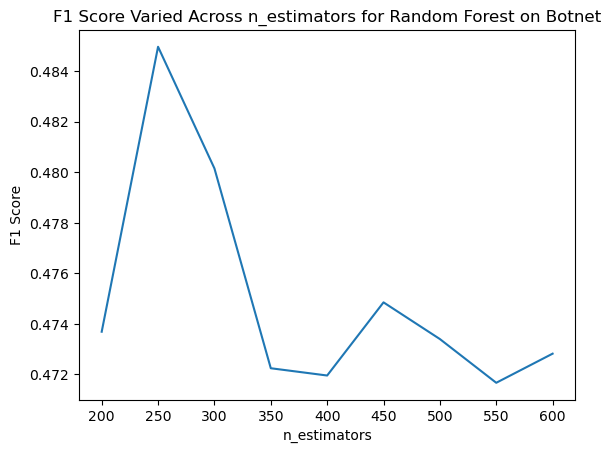

In [92]:
#Plot results
plt.plot(n_estimators_list, listF1)
plt.title('F1 Score Varied Across n_estimators for Random Forest on Botnet')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.show()

#### Error Analysis

In [93]:
#Create false positive, false negative, true positive and true negative collections
solver = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, max_features='sqrt', random_state=42, class_weight='balanced')
solver.fit(BotnetMon_x_train, BotnetMon_y_train)
solver_preds = solver.predict(BotnetMon_x_test)

false_pos = BotnetMon_x_test[(solver_preds == 1) & (BotnetMon_y_test == 0)]
false_neg = BotnetMon_x_test[(solver_preds == 0) & (BotnetMon_y_test == 1)]
true_pos = BotnetMon_x_test[(solver_preds == 1) & (BotnetMon_y_test == 1)]
true_neg = BotnetMon_x_test[(solver_preds == 0) & (BotnetMon_y_test == 0)]

In [94]:
#Find top 10 most important features for random forest splitting
rf_importances = pd.Series(solver.feature_importances_, index=BotnetMon_x_test.columns)
top10_rf = rf_importances.sort_values(ascending=False).head(10)
print(top10_rf)

Bwd Packet Length Mean     0.136118
Avg Bwd Segment Size       0.135268
Init_Win_bytes_forward     0.077094
Init_Win_bytes_backward    0.074811
Bwd Packet Length Max      0.068885
Average Packet Size        0.052690
Packet Length Mean         0.048921
Bwd Packet Length Min      0.030370
Total Backward Packets     0.024553
Min Packet Length          0.023807
dtype: float64


In [95]:
#Create subsets of false positive and false negative with only top 10 features
subset_false_pos = false_pos[['Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Bwd Packet Length Max', 'Average Packet Size','Packet Length Mean','Bwd Packet Length Min', 'Total Backward Packets', 'Min Packet Length']]
subset_false_neg = false_neg[['Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Bwd Packet Length Max', 'Average Packet Size','Packet Length Mean','Bwd Packet Length Min', 'Total Backward Packets', 'Min Packet Length']]
subset_true_pos = true_pos[['Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Bwd Packet Length Max', 'Average Packet Size','Packet Length Mean','Bwd Packet Length Min', 'Total Backward Packets', 'Min Packet Length']]
subset_true_neg = true_neg[['Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Bwd Packet Length Max', 'Average Packet Size','Packet Length Mean','Bwd Packet Length Min', 'Total Backward Packets', 'Min Packet Length']]

In [96]:
#Compare value counts to see if there are similarities b/t false pos and true pos
print(subset_false_pos.value_counts())
print(subset_true_pos.value_counts())

Bwd Packet Length Mean  Avg Bwd Segment Size  Init_Win_bytes_forward  Init_Win_bytes_backward  Bwd Packet Length Max  Average Packet Size  Packet Length Mean  Bwd Packet Length Min  Total Backward Packets  Min Packet Length
0.001584                0.001584              0.013947                0.003922                 0.000457               0.002443             0.002443            0.002796               0.000003                0.004415             168
                                              0.014450                0.003922                 0.000457               0.002443             0.002443            0.002796               0.000003                0.004415              66
                                              0.005127                0.003952                 0.000457               0.002443             0.002443            0.002796               0.000003                0.004415              48
                                              0.004379                0.003922     

In [97]:
#Compare value counts to see if there are similarities b/t false neg and true neg
print(subset_false_neg.value_counts())
print(subset_true_neg.value_counts())

Bwd Packet Length Mean  Avg Bwd Segment Size  Init_Win_bytes_forward  Init_Win_bytes_backward  Bwd Packet Length Max  Average Packet Size  Packet Length Mean  Bwd Packet Length Min  Total Backward Packets  Min Packet Length
0.000000                0.000000              0.003632                0.001694                 0.000000               0.000000             0.000000            0.000000               0.000003                0.000000             1
0.001584                0.001584              0.019165                0.003922                 0.000457               0.002443             0.002443            0.002796               0.000003                0.004415             1
                                              0.019867                0.003922                 0.000457               0.002443             0.002443            0.002796               0.000003                0.004415             1
                                              0.020554                0.003922           